In [1]:
print("ok")

ok


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.pandas.set_option("display.max_columns", None)


In [3]:
# Create DataFrame
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Print shape of dataset
print(df.shape)


(299, 13)


In [4]:
features_with_na = [feature for feature in df.columns if df[feature].isnull().sum() >= 1]

for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean()*100, 5), '% missing values')

features_with_na


[]

In [5]:
df.duplicated().sum()


np.int64(0)

In [6]:
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [7]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))
num_features


Num of Numerical Features : 13


['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'DEATH_EVENT']

In [8]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))


Num of Categorical Features : 0


In [9]:
discrete_features = [feature for feature in num_features if len(df[feature].unique()) <= 25]
continuous_features = [feature for feature in num_features if feature not in discrete_features]

print('Num of Discrete Features :', len(discrete_features))
print('Num of Continuous Features :', len(continuous_features))


Num of Discrete Features : 7
Num of Continuous Features : 6


In [10]:
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

y.head()


0    1
1    1
2    1
3    1
4    1
Name: DEATH_EVENT, dtype: int64

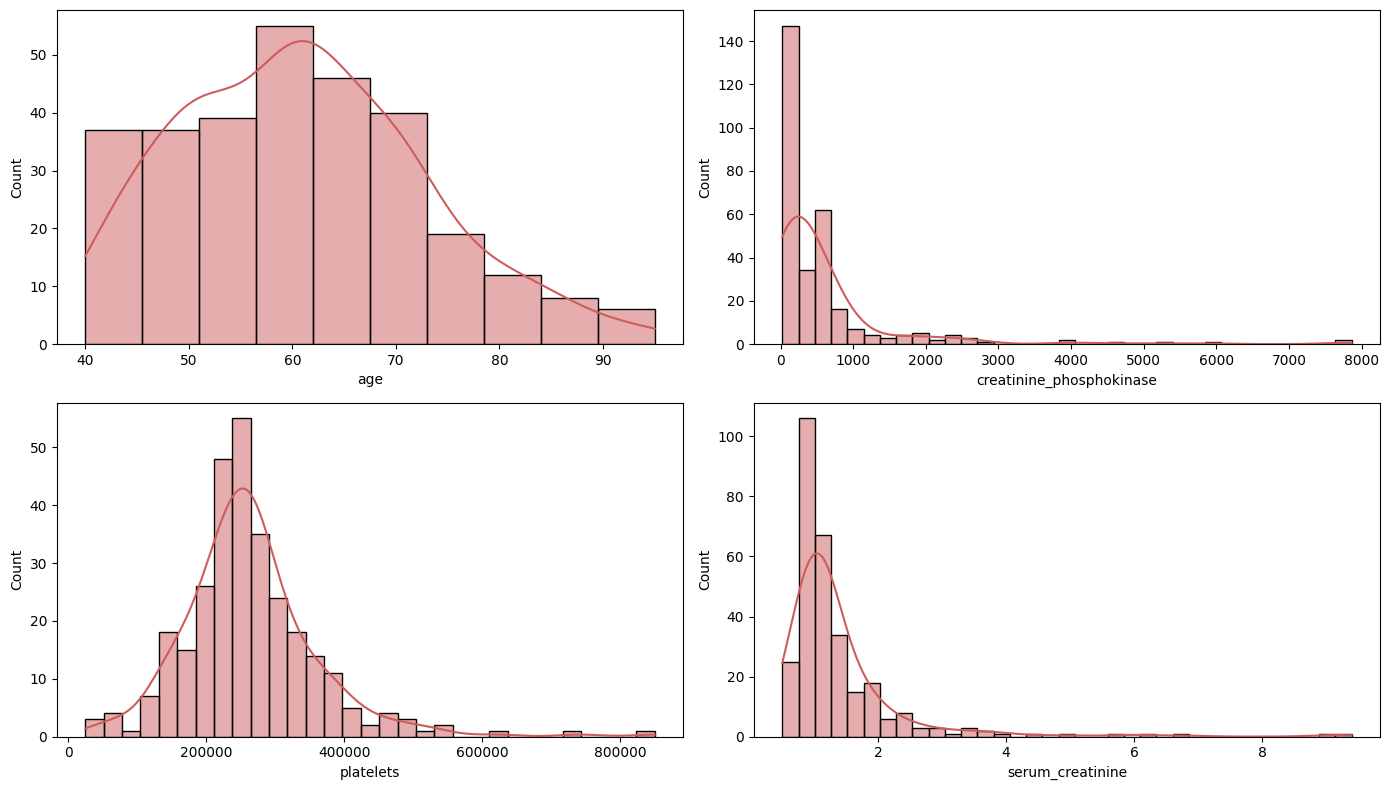

In [11]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(['age','creatinine_phosphokinase','platelets','serum_creatinine']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], kde=True, color='indianred')
    plt.xlabel(col)
    plt.tight_layout()


In [12]:
X[continuous_features].skew(axis=0, skipna=True)


age                         0.423062
creatinine_phosphokinase    4.463110
platelets                   1.462321
serum_creatinine            4.455996
serum_sodium               -1.048136
time                        0.127803
dtype: float64

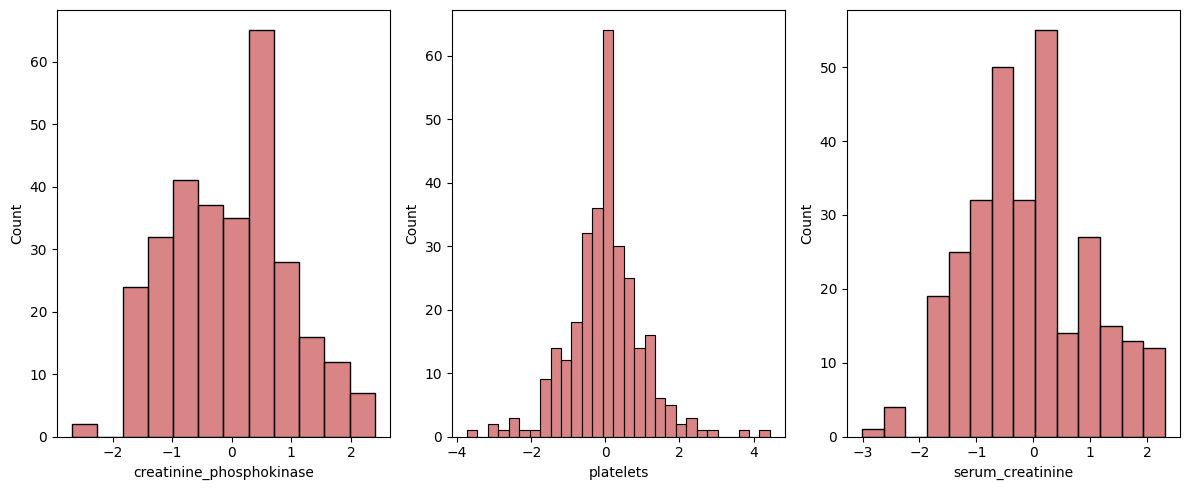

In [13]:
from sklearn.preprocessing import PowerTransformer

transform_features = [
    'creatinine_phosphokinase',
    'platelets',
    'serum_creatinine'
]

pt = PowerTransformer(method='yeo-johnson')
X_copy = pt.fit_transform(X[transform_features])
X_copy = pd.DataFrame(X_copy, columns=transform_features)

plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()


In [14]:
X_copy.skew(axis=0)


creatinine_phosphokinase    0.044225
platelets                   0.155360
serum_creatinine            0.150381
dtype: float64

In [15]:
num_features = list(X.columns)
num_features


['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time']

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

transform_pipe = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("PowerTransformer", transform_pipe, transform_features),
        ("StandardScaler", StandardScaler(), num_features)
    ],
    remainder='passthrough'
)

X = preprocessor.fit_transform(X)


In [17]:
from imblearn.combine import SMOTEENN

smt = SMOTEENN(random_state=42, sampling_strategy='minority')
X_res, y_res = smt.fit_resample(X, y)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((189, 15), (48, 15))

In [19]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [20]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1, precision, recall, roc_auc


In [21]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False),
    "SVC": SVC(),
    "AdaBoost": AdaBoostClassifier()
}


In [22]:
def evaluate_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models_list = []
    accuracy_list = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        acc, f1, prec, rec, roc = evaluate_clf(y_test, y_test_pred)

        print(name)
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"ROC-AUC: {roc:.4f}")
        print("="*35)

        models_list.append(name)
        accuracy_list.append(acc)

    return pd.DataFrame({
        "Model Name": models_list,
        "Accuracy": accuracy_list
    }).sort_values(by="Accuracy", ascending=False)


In [23]:
base_model_report = evaluate_models(X_res, y_res, models)
base_model_report


Random Forest
Accuracy: 0.9792
F1 Score: 0.9825
Precision: 0.9655
Recall: 1.0000
ROC-AUC: 0.9750
Decision Tree
Accuracy: 0.8542
F1 Score: 0.8772
Precision: 0.8621
Recall: 0.8929
ROC-AUC: 0.8464
Gradient Boosting
Accuracy: 0.9792
F1 Score: 0.9825
Precision: 0.9655
Recall: 1.0000
ROC-AUC: 0.9750
Logistic Regression
Accuracy: 0.9792
F1 Score: 0.9825
Precision: 0.9655
Recall: 1.0000
ROC-AUC: 0.9750
KNN
Accuracy: 0.9583
F1 Score: 0.9655
Precision: 0.9333
Recall: 1.0000
ROC-AUC: 0.9500
XGBoost
Accuracy: 0.9583
F1 Score: 0.9655
Precision: 0.9333
Recall: 1.0000
ROC-AUC: 0.9500
CatBoost
Accuracy: 0.9792
F1 Score: 0.9825
Precision: 0.9655
Recall: 1.0000
ROC-AUC: 0.9750
SVC
Accuracy: 0.9792
F1 Score: 0.9825
Precision: 0.9655
Recall: 1.0000
ROC-AUC: 0.9750
AdaBoost
Accuracy: 0.9583
F1 Score: 0.9643
Precision: 0.9643
Recall: 0.9643
ROC-AUC: 0.9571


,Model Name,Accuracy
0,Random Forest,0.979167
2,Gradient Boosting,0.979167
3,Logistic Regression,0.979167
7,SVC,0.979167
6,CatBoost,0.979167
5,XGBoost,0.958333
4,KNN,0.958333
8,AdaBoost,0.958333
1,Decision Tree,0.854167


In [26]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 15, 20],
    "max_features": ['sqrt', 'log2']
}

rf = RandomForestClassifier()

random_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_rf.fit(X_res, y_res)

random_rf.best_params_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 15}

In [27]:
best_model = RandomForestClassifier(**random_rf.best_params_)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("FINAL MODEL: Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred))


FINAL MODEL: Random Forest
Accuracy: 0.9375
